In [1]:
import keras
import numpy as np
import os
import os.path
import cv2
import glob
import imutils
from imutils import paths
import matplotlib.pyplot as plt 

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.backend import eval
from keras.utils import np_utils

C:\Users\Phil\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def resize_to_fit(image, width, height):
    
    (h, w) = image.shape[:2]
    
    if w > h:
        image = imutils.resize(image, width=width)
        
    else:
        image = imutils.resize(image, height=height)
        
    padW = int((width - image.shape[1]) / 2.0)
    padH = int((width - image.shape[0]) / 2.0)
    
    image = cv2.copyMakeBorder(image, padH, padH, padW, padW, cv2.BORDER_REPLICATE)
    image = cv2.resize(image, (width, height))
    
    return image


In [3]:
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"
OUTPUT_FOLDER = "extracted_letter_images"
OUTPUT_TEST_FOLDER = "extracted_letter_test_images"

In [4]:
captcha_image_files = glob.glob(os.path.join(CAPTCHA_IMAGE_FOLDER, "*"))
counts = {}

generate the images, put them into their respective directories.
LOOK BACK AT THIS LATER...

for (i, captcha_image_file) in enumerate(captcha_image_files):
    
    print("[INFO] processing image {}/{}".format(i + 1, len(captcha_image_files)))
    
    filename = os.path.basename(captcha_image_file)
    captcha_correct_text = os.path.splitext(filename)[0]
    
    image = cv2.imread(captcha_image_file)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    gray = cv2.copyMakeBorder(gray, 8, 8, 8, 8, cv2.BORDER_REPLICATE)
    
    thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contours = contours[0] if imutils.is_cv2() else contours[1]
    
    letter_image_regions = []
    
    
    for contour in contours:
        
        (x, y, w, h) = cv2.boundingRect(contour)
        
        if w / h > 1.25:
            
            half_width = int(w/2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            
            letter_image_regions.append((x, y, w, h))
            
    
    if len(letter_image_regions) != 4:
        continue
        
    
    
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])
    
    
    for letter_bounding_box, letter_text in zip(letter_image_regions, captcha_correct_text):
        
        x, y, w, h = letter_bounding_box
        
        letter_image = gray[y - 2:y + h + 2, x - 2:x + w + 2]
        
        save_path = os.path.join(OUTPUT_FOLDER, letter_text)
        save_path_test = os.path.join(OUTPUT_TEST_FOLDER, letter_text)
        
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        if not os.path.exists(save_path_test):
            os.makedirs(save_path_test)
            
        
        count = counts.get(letter_text, 1)
        if count > 1000:
            p = os.path.join(save_path_test, "{}.png".format(str(count-1000).zfill(6)))
        else:
            p = os.path.join(save_path, "{}.png".format(str(count).zfill(6)))
        cv2.imwrite(p, letter_image)
        
        counts[letter_text] = count + 1
    

In [5]:
# get the data from the folders
LETTER_IMAGES_FOLDER = "extracted_letter_images"
TEST_IMAGES_FOLDER = "extracted_letter_test_images"

#make the training data and testing data
x_train = []
y_train = []

x_test = []
y_test = []

#get the training data first from the folder
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = resize_to_fit(image, 20, 20)
    
    #might not need to be here...
    #image = np.expand_dims(image, axis=2)
    
    label = image_file.split(os.path.sep)[-2]
    
    x_train.append(image)
    y_train.append(label)
    
# get the testing data next, similar process as before
for image_file in paths.list_images(TEST_IMAGES_FOLDER):
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    image = resize_to_fit(image, 20, 20)
    
    label = image_file.split(os.path.sep)[-2]
    
    x_test.append(image)
    y_test.append(label)


# turn the inputs into arrays to make them easier to manipulate
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

print(x_train[0].shape)
print(y_train[0])

print('x_train original shape:', x_train.shape )
print('y_train original shape:', y_train.shape )
print('x_test original shape:', x_test.shape )
print('y_test original shape:', y_test.shape )

(20, 20)
2
x_train original shape: (32000, 20, 20)
y_train original shape: (32000,)
x_test original shape: (6744, 20, 20)
y_test original shape: (6744,)


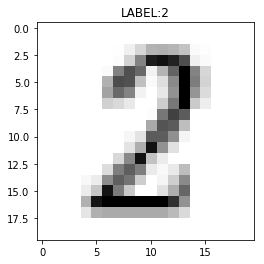

In [6]:
#show the data (for fun)
plt.imshow(x_train[1], cmap='gray', interpolation='none')
plt.title('LABEL:'+str(y_train[1]))
plt.show()

In [7]:
#reshape image data to be a 1D array rather than a 2D plane

x_train_flat = x_train.reshape(32000, 400)
x_test_flat = x_test.reshape(6744, 400)

print(x_train_flat.shape)
print(x_test_flat.shape)

(32000, 400)
(6744, 400)


In [8]:
#  normalize the pixel values to be between 1 and 0
x_train_flat = x_train_flat.astype('float32')
x_test_flat = x_test_flat.astype('float32')
x_train_flat /= 255
x_test_flat /= 255

In [9]:
#convert our labels into a 'one-hot' array
alphabet = "ABCDEFGHJKLMNPQRSTUVWXYZ23456789"
chr_to_idx = dict((c, i)for i,c in enumerate(alphabet))
idx_to_chr = dict((i, c)for i,c in enumerate(alphabet))

y_train_OH = np.zeros((len(y_train),len(alphabet)) )
y_test_OH = np.zeros((len(y_test),len(alphabet)) )

for i in range(len(y_train)):
    y_train_OH[i][chr_to_idx[y_train[i]]] = 1
    
for i in range(len(y_test)):
    y_test_OH[i][chr_to_idx[y_test[i]]] = 1

print(chr_to_idx)
print(chr_to_idx[y_train[0]])
print(y_train_OH[6])
print(y_test_OH[3])

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'J': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'U': 18, 'V': 19, 'W': 20, 'X': 21, 'Y': 22, 'Z': 23, '2': 24, '3': 25, '4': 26, '5': 27, '6': 28, '7': 29, '8': 30, '9': 31}
24
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0.]


In [16]:
model = Sequential()
model.add(Dense(512, input_shape=(400,)))
model.add(Activation('relu')) 

model.add(Dense(512))
model.add(Activation('relu'))

model.add(Dense(32))
model.add(Activation('softmax')) 

In [17]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
model.fit(x_train_flat, y_train_OH,
          batch_size=128, epochs=10, verbose=1,
          #show_accuracy=True, verbose=1)
          validation_data=(x_test_flat, y_test_OH))

Train on 32000 samples, validate on 6744 samples
Epoch 1/10
32000/32000 [==============================] - 4s 125us/step - loss: 0.5029 - acc: 0.8990 - val_loss: 0.1185 - val_acc: 0.9791
Epoch 2/10
32000/32000 [==============================] - 3s 79us/step - loss: 0.0678 - acc: 0.9888 - val_loss: 0.0791 - val_acc: 0.9841
Epoch 3/10
32000/32000 [==============================] - 3s 81us/step - loss: 0.0449 - acc: 0.9913 - val_loss: 0.0666 - val_acc: 0.9849
Epoch 4/10
32000/32000 [==============================] - 3s 82us/step - loss: 0.0348 - acc: 0.9926 - val_loss: 0.0499 - val_acc: 0.9870
Epoch 5/10
32000/32000 [==============================] - 3s 79us/step - loss: 0.0270 - acc: 0.9940 - val_loss: 0.0479 - val_acc: 0.9890
Epoch 6/10
32000/32000 [==============================] - 3s 79us/step - loss: 0.0231 - acc: 0.9944 - val_loss: 0.0547 - val_acc: 0.9868
Epoch 7/10
32000/32000 [==============================] - 3s 85us/step - loss: 0.0413 - acc: 0.9893 - val_loss: 0.0435 - val_acc

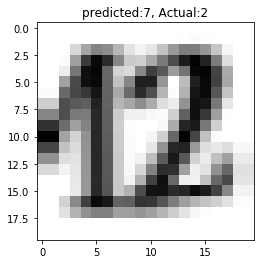

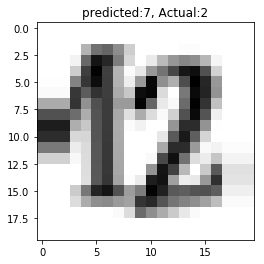

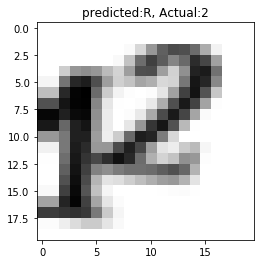

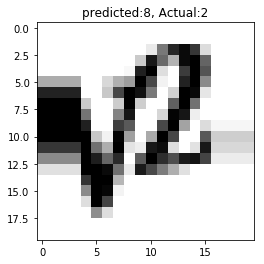

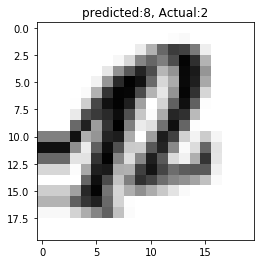

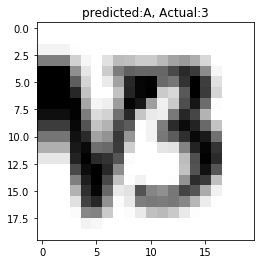

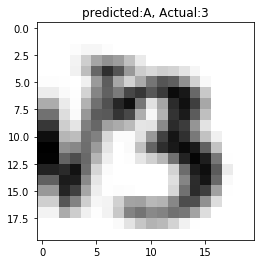

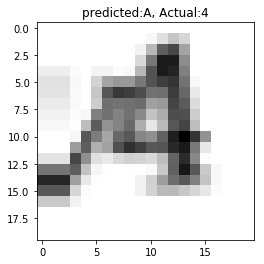

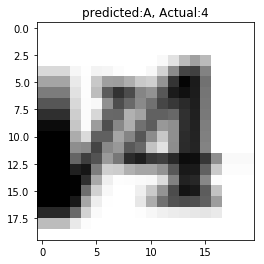

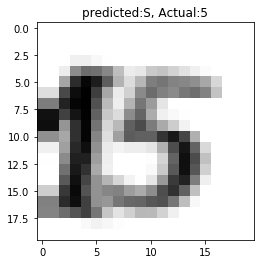

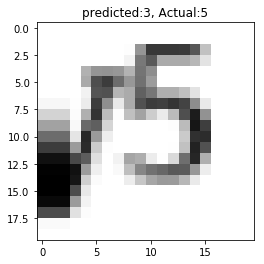

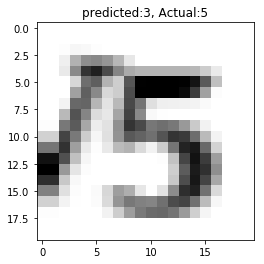

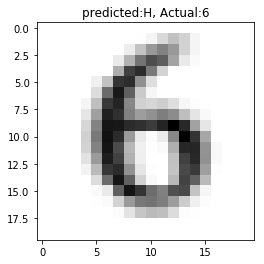

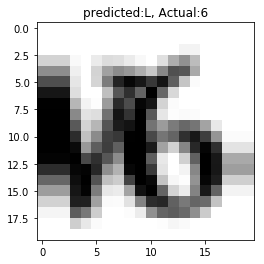

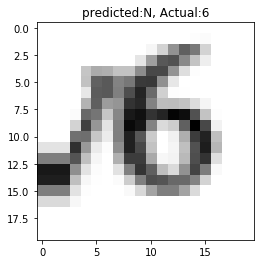

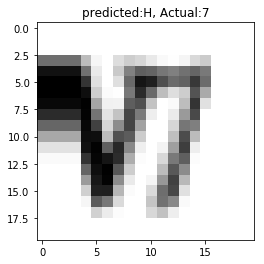

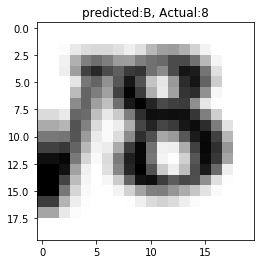

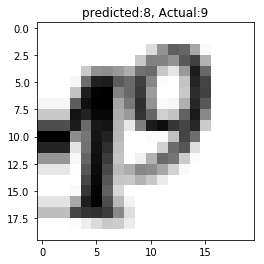

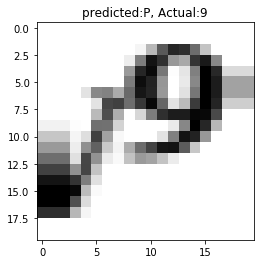

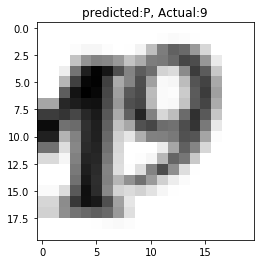

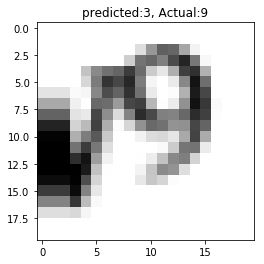

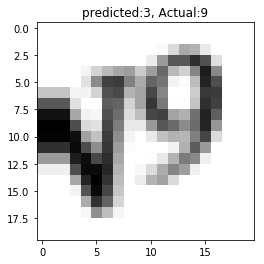

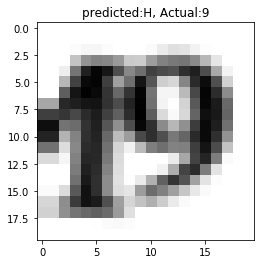

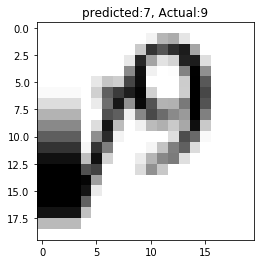

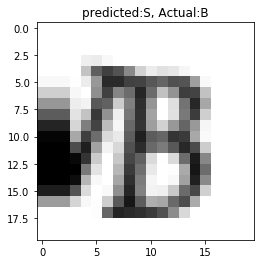

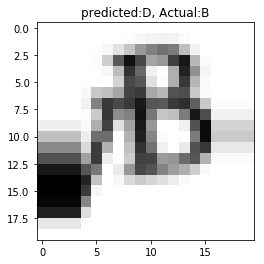

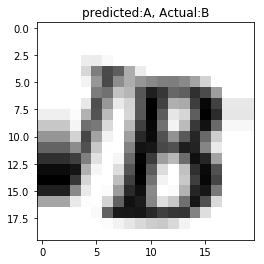

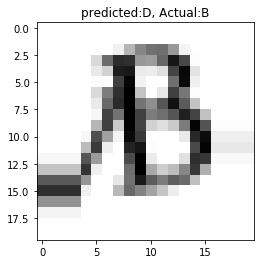

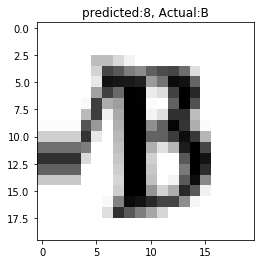

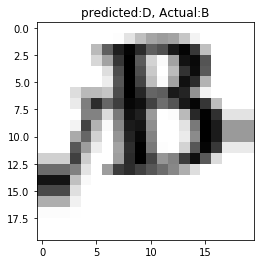

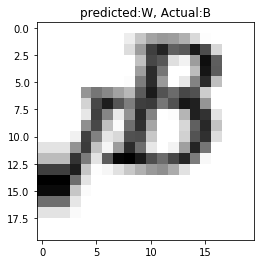

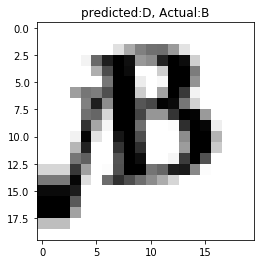

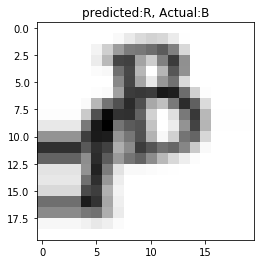

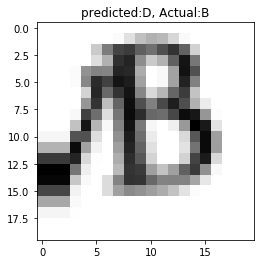

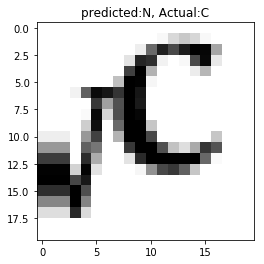

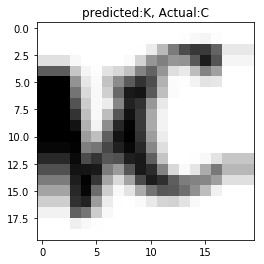

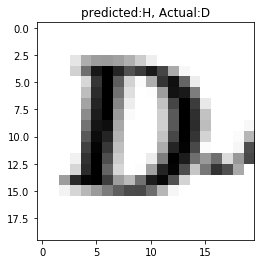

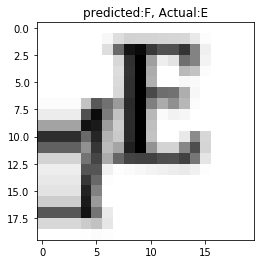

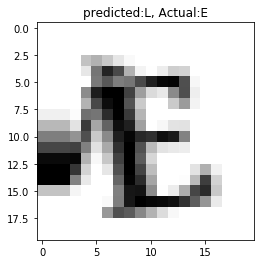

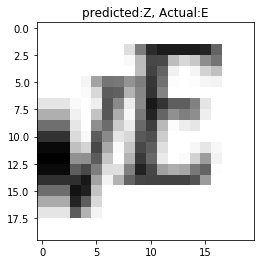

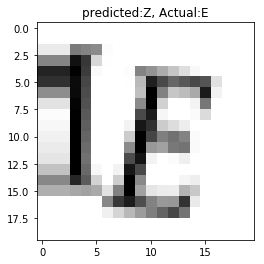

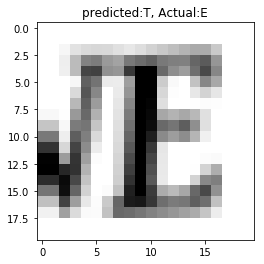

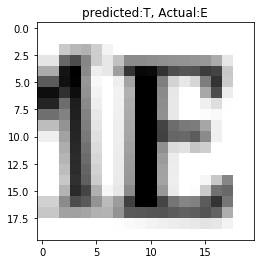

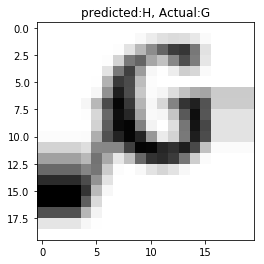

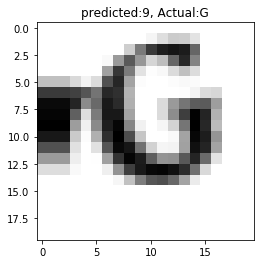

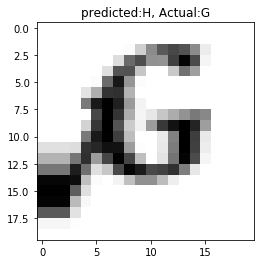

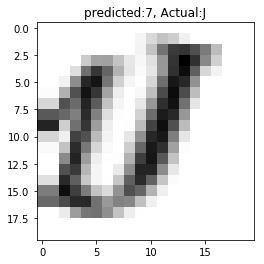

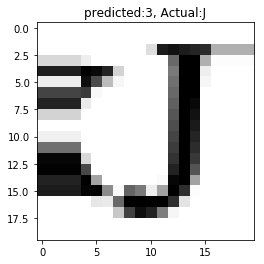

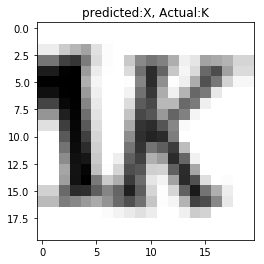

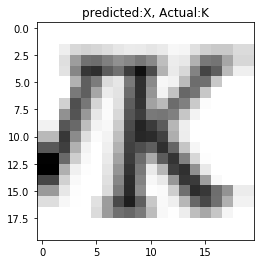

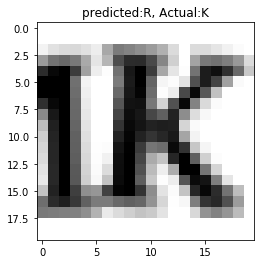

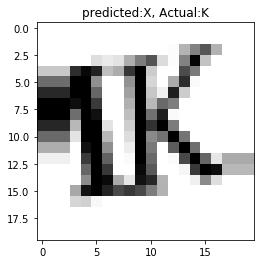

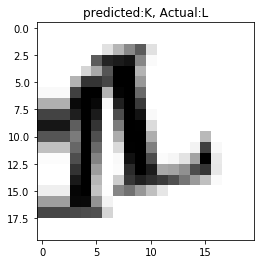

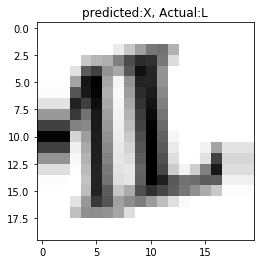

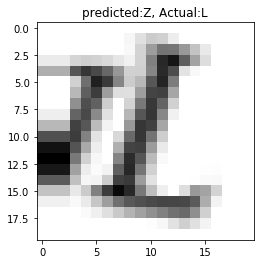

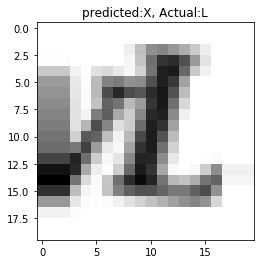

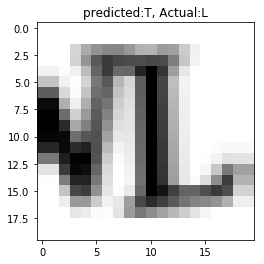

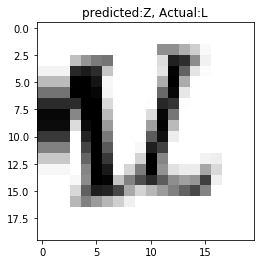

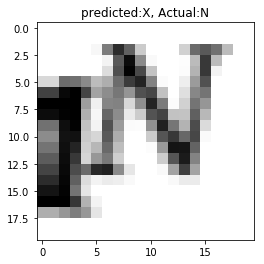

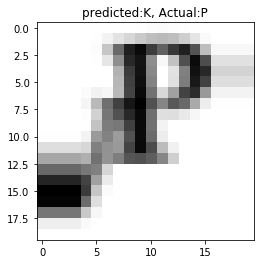

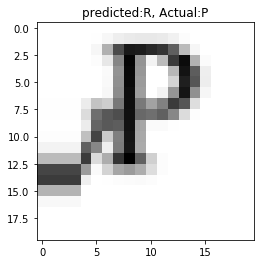

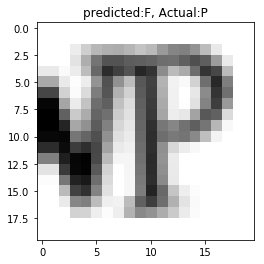

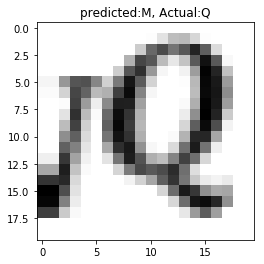

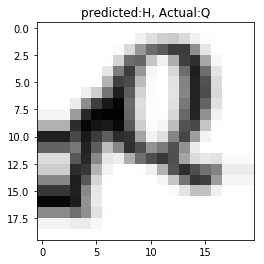

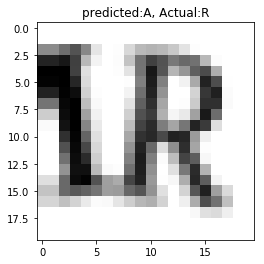

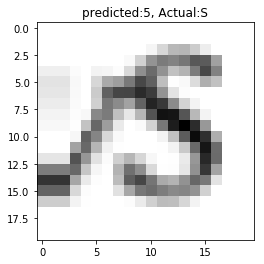

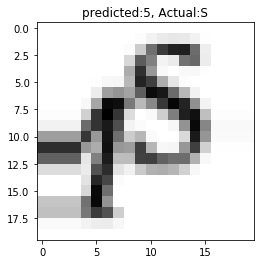

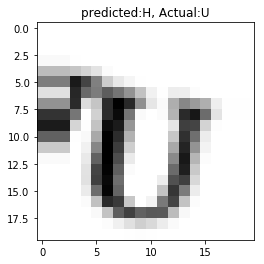

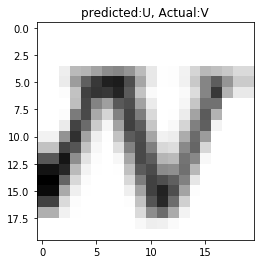

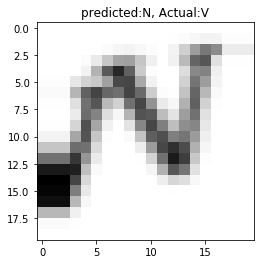

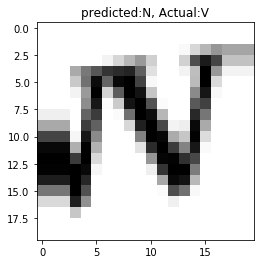

In total, I got 71 wrong out of 6744


In [33]:
predicted = model.predict_classes(x_test_flat)

count = 0

for i in range(len(predicted)):
    if idx_to_chr[predicted[i]] != y_test[i]:
        plt.imshow(x_test[i], cmap='gray', interpolation='none')
        plt.title('predicted:'+str(idx_to_chr[predicted[i]])+', Actual:'+str(y_test[i]))
        plt.show()
        count += 1
        
print("In total, I got",count,"wrong out of",len(predicted))

In [35]:
error = count /float(len(predicted)) * 100

print("My percent error was only:",error)

My percent error was only: 1.0527876631079478
